TODO:

1. High-precision refinement for small eigenvalues?
2. X Implement moving zeros to the middle of gaps
3. X Vary number of basis functions on each contour
4. Zabusky-Kruskal?
5. ?????? Explicit solve of one cut in the z-plane to give a preconditioner.
6. Prove $\Omega_{x,t}$ for 

$$ \Omega_j(x,t) = \Omega_{j,x} x + \Omega_{j,t} t + \Omega_{j,0}$$

If $\Omega_{j,t} t = 2 \pi i n_j$ for all $j$

In [1]:
include("./PeriodicKdV.jl")
using .PeriodicKdV
using LinearAlgebra, Plots, Printf
using ApproxFun

In [2]:
function T(λ,Q0,tspan)
    D = Derivative()
    B = Evaluation(tspan[1])
    A = [B               0;
         B*D             0;
         0               B;
         0               B*D;
         -D^2-(Q0+λ)*I   0;
         -I              -D^2-(Q0+λ)*I];
    u,udλ = A\[1;0;0;0;0;0]
    v,vdλ = A\[0;1;0;0;0;0]
    return [u(tspan[2]) v(tspan[2]);
    u'(tspan[2]) v'(tspan[2]);
    udλ(tspan[2]) vdλ(tspan[2]);
    udλ'(tspan[2]) vdλ'(tspan[2])]
end

function Δ(λ,Q0,tspan)
    Ts = T(λ,Q0,tspan)
   (Ts[1,1] + Ts[2,2])/2
end

function Δ2(λ,Q0,tspan)
    Ts = T(λ,Q0,tspan)
   ((Ts[1,1] + Ts[2,2])/2)^2
end

function Δ_newton_step(λ,σ,Q0,tspan)
    Ts = T(λ,Q0,tspan)
    δ = (Ts[1,1] + Ts[2,2] - 2*σ)/(Ts[3,1] + Ts[4,2])
    (λ - δ,δ)
end

function Δ2_newton_step(λ,Q0,tspan)
    Ts = T(λ,Q0,tspan)
    Δ = (Ts[1,1] + Ts[2,2])/2
    dΔ = (Ts[3,1] + Ts[4,2])/2
    δ = (Δ^2 - 1)/(2*Δ*dΔ)
    (λ - δ,δ)
end

function Δroot(λ,σ,Q0,tspan)
    λ0 = λ
    for i = 1:100
        (λ0,δ) = Δ_newton_step(λ0,σ,Q0,tspan)
        if abs(δ) < 1e-15
            break
        end
        if i == 100
            @warn "Max iter"
        end
    end
    λ0
end

function Δ2root(λ,Q0,tspan)
    λ0 = λ
    δ = 0.0
    for i = 1:200
        (λ0,δ) = Δ2_newton_step(λ0,Q0,tspan)
        if abs(δ) < 1e-14
            break
        end
        if i == 100
            @warn "Max iter"
        end
    end
    (λ0,δ)
end

function T12(λ,Q0,tspan)
    Ts = T(λ,Q0,tspan)
    Ts[1,2]
end

function T12_newton_step(λ,Q0,tspan)
    Ts = T(λ,Q0,tspan)
    δ = Ts[1,2]/Ts[3,2]
    (λ - δ,δ)
end

function T12root(λ,Q0,tspan)
    λ0 = λ
    δ = 0.0
    for i = 1:100
        (λ0,δ) = T12_newton_step(λ0,Q0,tspan)
        if abs(δ) < 1e-14
            break
        end
        if i == 100
            @warn "Max iter"
        end
    end
    (λ0,δ)
end

sqz = z -> sqrt(z-1 |> complex)*sqrt(1+z |> complex)

function find_sheet(λ,Q0,tspan)
    TT = T(λ+1im*1e-14,Q0,tspan)
    dd = (TT[1,1] + TT[2,2])/2
    sqdd = sqz(dd)
    #return -sign(imag(dd^2))
    #println(imag(dd^2) |> sign)
    s1 = sqdd + 1/2*(TT[2,2]-TT[1,1]) |> abs
    s2 = -sqdd + 1/2*(TT[2,2]-TT[1,1]) |> abs
    #println((s1,s2))
    if s1 > s2 # pole on sheet 1
        σ = 1.0
    else
        σ = -1.0 # pole on sheet 2
    end
    return σ
end

find_sheet (generic function with 1 method)

We know how to solve

$$ q_t + 6 q_x q + q_{xxx} = 0.$$

If we set $u(x,t) = a q(bx,ct)$ then we find that $u$ solves

$$\frac{1}{ca} u_t + \frac{6}{ba^2} u_x u + \frac{1}{b^3 a} u_{xxx} = 0.$$

We need to choose $c,a,b$ so that $u$ solves

$$ u_t + uu_x + \delta^2 u_{xxx} = 0.$$

To match Zabusky and Kruskal we set $c = b$, $a = 6$ and $b = 1/\delta$. Or to keep the period bounded, set $b = O(1)$ and 

$$ \frac{6c}{a b} = 1, \quad \frac{c}{b^3} = \delta^2.$$

So if $u(x,0) = \cos \pi x$ then $q(x,0) = \frac{1}{a} \cos \frac{\pi x}{b}$ 

In [3]:
δ = 0.022
b = 4.0
c = b^3*δ^2
a = (6c)/b

0.04646399999999999

In [8]:
q0 = x -> 1/a*cos((x-0.1)*pi/b)
tspan = (0.0,2*b)

(0.0, 8.0)

$$-\mu_{xx} - q_0(x) \mu = \lambda \mu, \quad z^2 = \lambda - \alpha_1.$$

$$ \begin{bmatrix} i v_x \\ -i w_x \end{bmatrix} - \begin{bmatrix} 0 & i q_0(x) \\ i & 0 \end{bmatrix}\begin{bmatrix} v \\ w \end{bmatrix} = z\begin{bmatrix} v \\ w \end{bmatrix} $$

In [85]:
d = ApproxFun.PeriodicSegment(tspan[1],2*tspan[2]) # supposes tspan[1] = 0
Q0per = Fun(q0,d)
D = Derivative(Q0per.space)
L = -D^2 - Q0per
λPer, v = ApproxFun.eigs(L,1000, tolerance = 1.0);
λPer_old = λPer |> sort;

In [86]:
α1 = λPer_old[1]

-18.984776830932

In [110]:
d = ApproxFun.PeriodicSegment(tspan[1],2*tspan[2]) # supposes tspan[1] = 0
Q0per = Fun(q0,d) + α1 + 1e-14
D = Derivative(Q0per.space)
L = [1im*D    -1im*Q0per;
     -1im*I    -1im*D]
λPer = ApproxFun.eigvals(L, 1000, tolerance = 1.0)
λPer_new = real(λPer) |> sort
λPer_new[λPer_new .> 0.0] |> minimum

7.776144660536576e-6

In [111]:
d = ApproxFun.PeriodicSegment(tspan[1],2*tspan[2]) # supposes tspan[1] = 0
Q0per = Fun(q0,d) + α1
D = Derivative(Q0per.space)
L = [1im*D    -1im*Q0per;
     -1im*I    -1im*D]
λPer = ApproxFun.eigvals(L, 1000, tolerance = 100.0)
λPer_new = real(λPer) |> sort
λPer_new[λPer_new .> 0.0] |> minimum

7.774672325875191e-6

In [95]:
v = λPer_new[λPer_new .> 0.0][1:10]
w = sqrt.(λPer_old .- α1)[1:10]
v - w

10-element Array{Float64,1}:
  7.774672325875191e-6
  2.9458615334593055e-8
  4.658495811327157e-13
 -8.539835505416704e-13
  1.6475709685437323e-12
  6.186162693211372e-13
 -4.0456527017340704e-13
  1.2390088954816747e-13
 -7.637446231001377e-12
  2.7711166694643907e-13

In [97]:
hcat(v,w)

10×2 Array{Float64,2}:
 7.77467e-6  0.0
 7.80301e-6  7.77355e-6
 2.23464     2.23464
 2.23464     2.23464
 3.13383     3.13383
 3.13383     3.13383
 3.80422     3.80422
 3.80422     3.80422
 4.35146     4.35146
 4.35146     4.35146

In [67]:
w

10-element Array{Float64,1}:
 0.0
 4.3392836387637365e-7
 2.234637196142103
 2.2346371961500187
 3.1338344214205454
 3.1338344217485776
 3.8042246079530915
 3.8042246178782344
 4.351458554583963
 4.3514587782008025

In [15]:
u(x,t) = a*q(b*x,c*t)

u (generic function with 1 method)

Want

$$ u(x,0) = \cos \pi x.$$

Choose $q(x,0) = \frac 1 a \cos \frac{\pi x}{b}$.

In [16]:
1/a |> display
2*b

21.522038567493116

8.0

In [17]:
q0 = x -> 1/a*cos((x-0.1)*pi/b)
tspan = (0.0,2*b)
Q0 = Fun(q0,tspan[1]..tspan[2])
Q0per = Fun(q0,ApproxFun.PeriodicSegment(tspan...))
D = Derivative()
B = Evaluation(tspan[1])

ConcreteEvaluation : ApproxFunBase.UnsetSpace() → ConstantSpace


In [74]:
k = 14;

In [75]:
sp = Q0.space
BC = Dirichlet(sp)
D = Derivative()
L = -D^2 - Q0
λDir, v = ApproxFun.eigs(BC,L,100, tolerance = 1e-15);
λDir = λDir |> sort
σs = map(y -> find_sheet(y,Q0,tspan), λDir[1:k]);
σs |> display
#σs = σs.*[(-1)^(j+1) for j in 1:k];

14-element Array{Float64,1}:
 -1.0
 -1.0
  1.0
 -1.0
  1.0
 -1.0
  1.0
 -1.0
 -1.0
  1.0
 -1.0
  1.0
 -1.0
  1.0

In [23]:
λPer[1:6] .- λPer[1]

6-element Array{Float64,1}:
 0.0
 1.8829382497642655e-13
 4.99360339838184
 4.993603398417218
 9.820918180880243
 9.820918182936241

In [18]:
d = ApproxFun.PeriodicSegment(tspan[1],2*tspan[2]) # supposes tspan[1] = 0
Q0per = Fun(q0,d)
D = Derivative(Q0per.space)
L = -D^2 - Q0per
λPer, v = ApproxFun.eigs(L,100, tolerance = 1e-15);
λPer = λPer |> sort;

In [77]:
α1 = λPer[1]
α = λPer[3:2:2k+1] .- α1
β = λPer[2:2:2k] .- α1
gaps = hcat(β,α)
zs = hcat(λDir[1:k] .- α1, σs)
gaps |> display
gaps[:,2] - gaps[:,1] |> display
zs |> display

14×2 Array{Float64,2}:
    0.000112899   154.307
  154.313         296.78
  296.936         424.409
  426.515         528.515
  543.982         603.262
  657.195         676.851
  779.464         782.732
  920.469         920.802
 1082.97         1082.99
 1266.75         1266.75
 1471.28         1471.28
 1696.23         1696.23
 1941.39         1941.39
 2206.62         2206.62

14-element Array{Float64,1}:
 154.30665762391413
 142.46677219200916
 127.47389972253308
 101.99959545828312
  59.279532060708675
  19.656422392602963
   3.2682464950369194
   0.3320346608670661
   0.0242203818447706
   0.0013574252459420677
   6.0727575601049466e-5
   2.2264528070081724e-6
   6.823847797932103e-8
   1.7835191101767123e-9

14×2 Array{Float64,2}:
   45.0055  -1.0
  272.886   -1.0
  333.407    1.0
  484.243   -1.0
  589.662    1.0
  662.085   -1.0
  782.562    1.0
  920.47    -1.0
 1082.99    -1.0
 1266.75     1.0
 1471.28    -1.0
 1696.23     1.0
 1941.39    -1.0
 2206.62     1.0

In [78]:
gap_test = map( (x,y,z) ->  x <= y <= z, gaps[:,1], zs[:,1], gaps[:,2])  # should be all 1's
for i = 1:length(gap_test)
    if gap_test[i] == 0
        @warn "Zero not in gap.  Error estimate: "*string(min(abs(zs[i,1]-gaps[i,2]),abs(zs[i,1]-gaps[i,1])))
        if zs[i,1] > gaps[i,2]
            zs[i,1] = gaps[i,2]
        else
            zs[i,1] = gaps[i,1]
        end
    end
end

In [86]:
S = HyperellipticSurface(gaps,zs,5000);

In [87]:
BA = BakerAkhiezerFunction(S,60,1e-6);

Effective rank of Cauchy operator = 3034
Maximum rank of Cauchy operator = 47040


In [89]:
map(z -> abs.(out[1](z,1)),sqrt.(zs[:,1]))

14-element Array{Array{Float64,2},1}:
 [1.5917383973396169 0.08901350675788394]
 [1.0138520619194087 0.27288551972647274]
 [0.6678422195782139 0.6222024555209665]
 [2.8710911505050447 0.19720161412288995]
 [0.3847636193292276 2.8798556259663455]
 [1.8718650342471486 0.19633146789016814]
 [0.5239483581655674 3.41798621922427]
 [0.11787843221613904 0.09445826889634845]
 [1.2485360366683578 1.2485360366683589]
 [1.1916546973966582 1.1916546973966589]
 [1.1535153903031055 1.1535153903031063]
 [1.1262375367886863 1.1262375367886872]
 [1.1058865992470888 1.1058865992470892]
 [1.0902251762746706 1.090225176274671]

In [90]:
q(x,t) = KdV(BA, x+6*α1*t, t) - α1

q (generic function with 1 method)

In [91]:
q(0.0,0.0) - q0(0.0)

-11.464243147373622 + 1.672470267653674e-12im

In [92]:
q(1.0,0.0) - q0(1.0)

-11.46423765889034 + 3.6381581845140695e-12im

In [93]:
out = BA(0.0,0.0,1e-14);

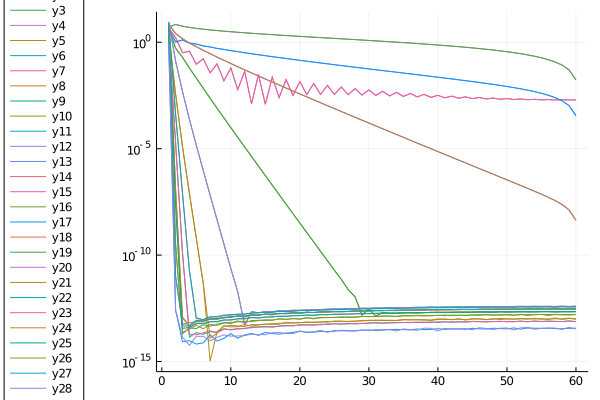

In [94]:
p = plot(abs.(out[2][1].cs), yaxis = :log)
for j = 2:length(out[2])
    plot!(abs.(out[2][j].cs), yaxis = :log, legend = :outerleft)
end
p

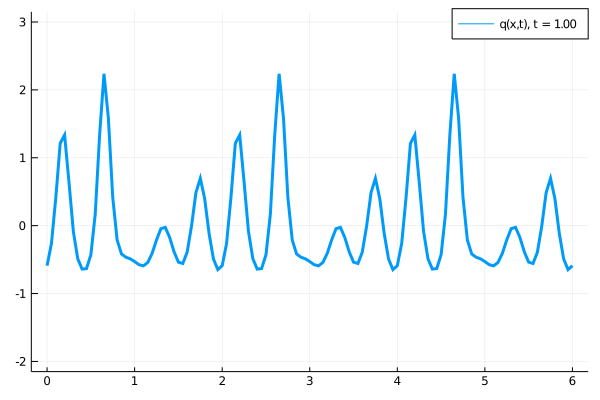

┌ Info: Saved animation to 
│   fn = /Users/thomastrogdon/Dropbox (uwamath)/Projects/Collaborations/Periodic KdV/PeriodicKdV/test3.gif
└ @ Plots /Users/thomastrogdon/.julia/packages/Plots/jpF9l/src/animation.jl:104


Plots.AnimatedGif("/Users/thomastrogdon/Dropbox (uwamath)/Projects/Collaborations/Periodic KdV/PeriodicKdV/test3.gif")
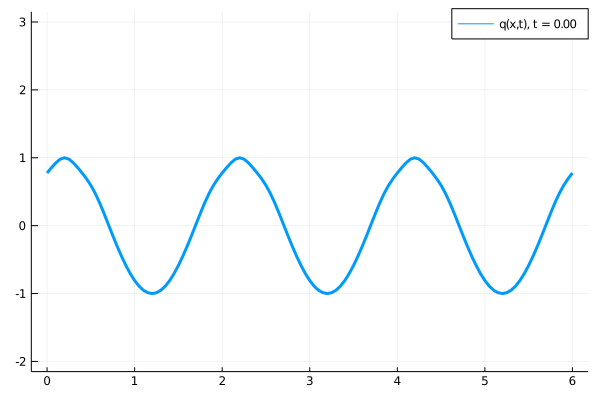

In [95]:
Tend = 1
kk = 0.1
n = convert(Int64,ceil(Tend/kk))
plot()
anim = Animation()
t = 0.0
x = 0:0.05:6 |> Array
U = map(x -> u(x,t) |> real, x);
p = plot(x, U, xaxis = [minimum(x),maximum(x)], yaxis = [-2,3],lw=3,label = @sprintf("q(x,t), t = %1.2f",t))
frame(anim)
p |> IJulia.display
for i = 2:n+1
    t += kk
    IJulia.clear_output(true)
    U = map(x -> u(x,t) |> real, x);
    p = plot(x, U, xaxis = [minimum(x),maximum(x)], yaxis = [-2,3],lw=3,label = @sprintf("q(x,t), t = %1.2f",t))
    frame(anim)
    p |> IJulia.display
end
gif(anim,"test3.gif")